In [90]:
import pandas as pd
import numpy as np
import whois
from urllib.parse import urlparse,urlencode
import ipaddress
import re
import math
import requests
from urllib.parse import urlparse,urlencode
from datetime import datetime
from tqdm.notebook import tqdm
from collections import Counter
from sklearn.preprocessing import LabelBinarizer
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from prettytable import PrettyTable


# datasets


In [237]:
# https://www.phishtank.com/developer_info.php
df_phishing = pd.read_csv('FinalDataset/URL/phishing_dataset.csv',names = ["url"])
df_phishing =  pd.concat([df_phishing, pd.read_csv('phising_tank.csv')[["url"]]])
df_phishing["label"] = 1
df_phishing = df_phishing.drop_duplicates()
df_phishing

,url,label
0,http://v2.email-marketing.adminsimple.com/trac...,1
1,http://bid.openx.net/json?amp;amp;amp;amp;cid;...,1
2,http://webmail2.centurytel.net/hwebmail/servic...,1
3,http://www.google.com.ng/imgres?imgurl=http://...,1
4,http://webmail2.centurytel.net/hwebmail/servic...,1
...,...,...
5658,http://www.formbuddy.com/cgi-bin/formdisp.pl?u...,1
5659,http://www.formbuddy.com/cgi-bin/formdisp.pl?u...,1
5660,https://sites.google.com/site/libretyreserve/,1
5661,http://sites.google.com/site/habbotuttogratis,1


In [240]:
df_leg_link = pd.read_csv('FinalDataset/URL/Benign_list_big_final.csv',names = ["url"])
df_leg_link = df_leg_link.sample(n = len(df_phishing), random_state = 12).copy()
df_leg_link = df_leg_link.reset_index(drop=True)
df_leg_link["label"] = 0
df_leg_link

,url,label
0,http://graphicriver.net/search?date=this-month...,0
1,https://foursquare.com/v/%D1%81%D0%B0%D0%B2%D0...,0
2,http://shop-pro.jp/magazine/wp-content/themes/...,0
3,http://motthegioi.vn/the-gioi-xe/o-to-chat-luo...,0
4,http://tobogo.net/cdsb/board.php?board=dailyst...,0
...,...,...
15610,http://otomoto.pl/oferta/zuraw-farma-niab-pl-d...,0
15611,https://medium.com/thelist/why-i-m-returning-t...,0
15612,http://babal.net/books/view/406/%D9%82%D8%A7%D...,0
15613,http://otomoto.pl/oferta/bmw-seria-3-bmw-e46-c...,0


In [241]:
df_phis_leg = pd.concat([df_phishing[["url","label"]],df_leg_link])
df_phis_leg = df_phis_leg.reset_index()

# Feature extraction

![title](./url_hirearchy.png)

In [242]:

class UrlFeaturizer(object):
    def __init__(self, url):
        self.url = url
        self.domain = url.split('//')[-1].split('/')[0]
        self.today = datetime.now()

        try:
            self.whois = None  # whois.whois(self.domain)
        except:
            self.whois = None

        try:
            self.response = None #requests.get(self.url)
        except:
            self.response = None

    ## URL string Features
    def entropy(self):
        prob = [float(self.url.count(c)) / len(self.url) for c in dict.fromkeys(list(self.url))]
        entropy = sum([(p * math.log(p) / math.log(2.0)) for p in prob])
        return entropy

    def num_digits(self):
        digits = [i for i in self.url if i.isdigit()]
        return len(digits)

    def url_length(self):
        parse = urlparse(self.url)
        url = parse.netloc + parse.path
        return len(url)

    def num_parameters(self):
        params = urlparse(self.url).query.split('&')
        return len(params)

    def num_fragments(self):
        fragments = urlparse(self.url).fragment.split('#')
        return len(fragments)

    def domain_extension(self):
        ext = self.url.split('.')[-1].split('/')[0]
        return ext

    ## URL domain features

    def has_https(self):
        return 'https:' in self.url

    def url_is_live(self):
        return self.response == 200

    def days_since_registration(self):
        try:
            if self.whois and 'creation_date' in self.whois:
                if isinstance(self.whois['creation_date'], list):
                    creation_date = self.whois['creation_date'][0]
                else:
                    creation_date = self.whois['creation_date']

                diff = self.today - creation_date
                diff = diff.days
                return diff
            else:
                return 0
        except:
            print(self.url)
            print(self.whois)
            return None

    def days_since_expiration(self):
        try:
            if self.whois and 'expiration_date' in self.whois:
                if isinstance(self.whois['expiration_date'], list):
                    expiration_date = self.whois['expiration_date'][0]
                else:
                    expiration_date = self.whois['expiration_date']

                diff = expiration_date - self.today
                diff = str(diff).split(' days')[0]
                return diff
            else:
                return 0
        except:
            print('daysSinceExpiration')
            print(self.url)
            print(self.whois)
            return None

    def have_at_sign(self):
        return 1 if "@" in self.url else 0

    def url_depth(self):
        s = urlparse(self.url).path.split('/')
        depth = 0
        for j in range(len(s)):
            if len(s[j]) != 0:
                depth = depth + 1
        return depth

    def redirection(self):
        parse = urlparse(self.url)
        url = parse.netloc + parse.path
        return 0 if url.rfind('//') == -1 else 1

    def num_dash(self):
        return self.url.count('-')

    def num_under_score(self):
        return self.url.count('_')

    def num_dots(self):
        return self.url.count('.')

    def get_page_rank(self):
        raise NotImplementedError

    def run(self):
        data = {}

        data['entropy'] = self.entropy()
        data['num_digits'] = self.num_digits()
        data['have_at_sign'] = self.have_at_sign()
        data['url_length'] = self.url_length()
        data['num_parameters'] = self.num_parameters()
        data['has_https'] = self.has_https()
        data['url_is_live'] = self.url_is_live()
        data['url_depth'] = self.url_depth()
        data['num_dots'] = self.num_dots()
        data['redirection'] = self.redirection()
        data['num_dash'] = self.num_dash()
        data['num_under_score'] = self.num_under_score()
        data['ext'] = self.domain_extension()
        #         data['dsr'] = self.daysSinceRegistration()
        #         data['dse'] = self.days_since_expiration()
        return data

In [252]:
url_features = UrlFeaturizer("www.google.com")
features = url_features.run()
all_features = []
columns = list(features.keys())
df = df_phis_leg.copy()
for i, row in tqdm(df.iterrows()):
    url = row["url"]
    url_features = UrlFeaturizer(url)
    features = url_features.run()       
    all_features.append(list(features.values()))

      
df[columns] = all_features

ext_relevant = [key for key,value in Counter(df["ext"]).items() if value >500]
df['ext_relevant'] = df['ext'].apply(lambda x: x if x in ext_relevant else 'general')
df['ext_relevant'] = df['ext_relevant'].astype('category')

df_ext_onehot_sklearn = df.copy()
lb = LabelBinarizer()
lb_results = lb.fit_transform(df_ext_onehot_sklearn['ext_relevant'])
lb_results_df = pd.DataFrame(lb_results, columns=lb.classes_)

result_df = pd.concat([df, lb_results_df], axis=1)
result_df

,index,url,label,entropy,num_digits,have_at_sign,url_length,num_parameters,has_https,url_is_live,...,num_under_score,ext,ext_relevant,com,general,htm,html,net,php,uk
0,0,http://v2.email-marketing.adminsimple.com/trac...,1,-5.164845,45,0,45,6,False,False,...,1,com,com,1,0,0,0,0,0,0
1,1,http://bid.openx.net/json?amp;amp;amp;amp;cid;...,1,-4.914993,48,0,18,6,False,False,...,1,com,com,1,0,0,0,0,0,0
2,2,http://webmail2.centurytel.net/hwebmail/servic...,1,-4.952511,79,0,48,1,False,False,...,1,138,general,0,1,0,0,0,0,0
3,3,http://www.google.com.ng/imgres?imgurl=http://...,1,-4.746903,11,0,24,4,False,False,...,1,,general,0,1,0,0,0,0,0
4,4,http://webmail2.centurytel.net/hwebmail/servic...,1,-4.923671,69,0,48,1,False,False,...,1,it,general,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31225,15610,http://otomoto.pl/oferta/zuraw-farma-niab-pl-d...,0,-4.520081,2,0,138,1,False,False,...,0,html,html,0,0,0,1,0,0,0
31226,15611,https://medium.com/thelist/why-i-m-returning-t...,0,-4.618182,9,0,63,1,True,False,...,0,com,com,1,0,0,0,0,0,0
31227,15612,http://babal.net/books/view/406/%D9%82%D8%A7%D...,0,-3.704147,71,0,203,1,False,False,...,0,net,net,0,0,0,0,1,0,0
31228,15613,http://otomoto.pl/oferta/bmw-seria-3-bmw-e46-c...,0,-4.471543,11,0,76,1,False,False,...,0,html,html,0,0,0,1,0,0,0


In [253]:
data = df
objects = [i for i in data.columns if 'object' in str(data.dtypes[i])]
booleans = [i for i in data.columns if 'bool' in str(data.dtypes[i])]
ints = [i for i in data.columns if 'int' in str(data.dtypes[i]) or 'float' in str(data.dtypes[i])]

<AxesSubplot:>

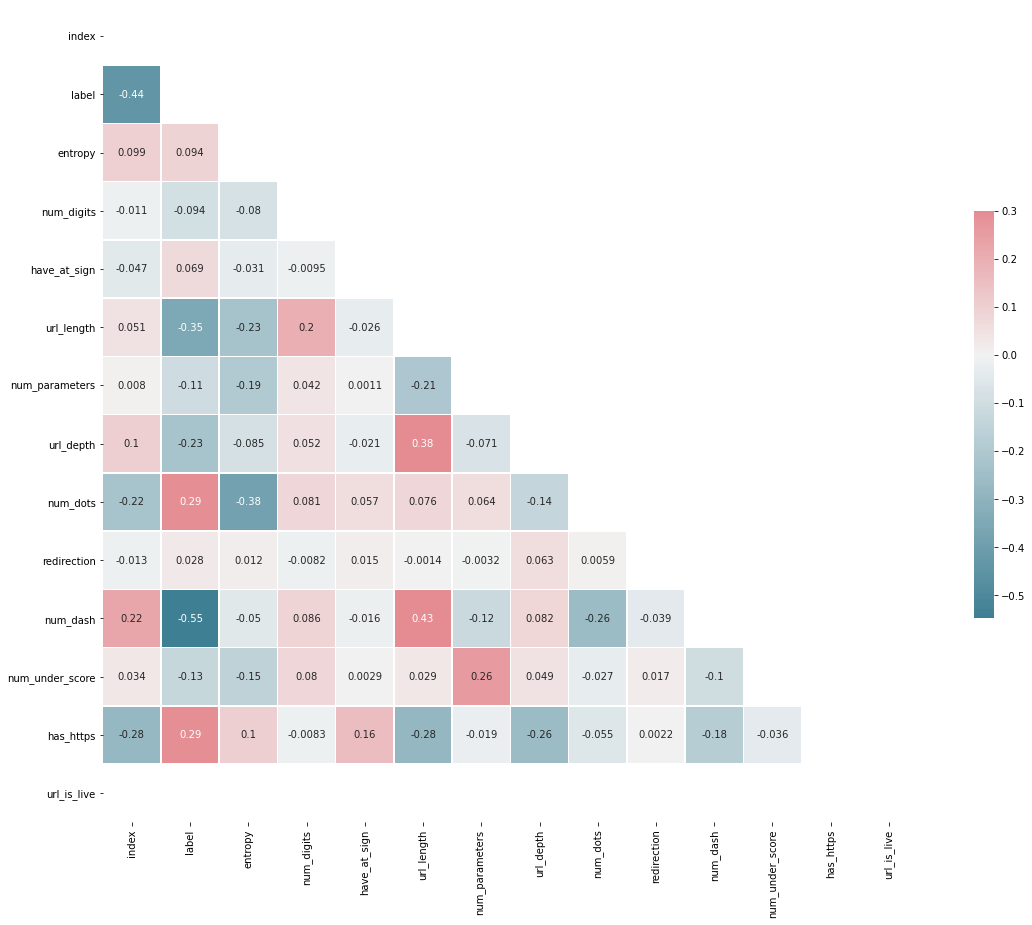

In [254]:
import numpy as np
corr = data[ints+booleans].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 15))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

In [257]:
data = result_df.sample(frac=1).reset_index(drop=True)

In [258]:
y = data['label']
X = data.drop(['label',"index","url","ext", 'ext_relevant'],axis=1)
X.shape, y.shape

((31230, 19), (31230,))

In [259]:
# Splitting the dataset into train and test sets: 80-20 split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, random_state = 12)
X_train.shape, X_test.shape

((24984, 19), (6246, 19))

# Models

In [ ]:
def plot_confusion_matrix(conf_matrix):
    ax= plt.subplot()
    sns.heatmap(conf_matrix, annot=True, ax = ax, fmt='g')
    ax.set_ylabel('Predicted labels')
    ax.set_xlabel('True labels')
    ax.set_title('Train Confusion Matrix') 
    ax.xaxis.set_ticklabels(['negative', 'positive']) 
    ax.yaxis.set_ticklabels(['negative', 'positive'])
    
def plot_feature_importances(n_features, feature_importances, columns):
    plt.figure(figsize=(9,7))
    plt.barh(range(n_features), feature_importances, align='center')
    plt.yticks(np.arange(n_features), X_train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.show()

In [320]:
# Creating holders to store the model performance results

class ModelSummaryTable(object):
    def __init__(self):
        self.table = PrettyTable()
        self.table.field_names = ["Algorithm", "Train Accuracy", "Test Accuracy", "Max_depth", "n_estimators"]
    
    def add_row(self, algo,accuracy,f1_score, max_depth = None, n_est = None):
        self.table.add_row([algo, accuracy, f1_score,  max_depth, n_est])
    
    def show(self):
        print(self.table)
        
summary_table =   ModelSummaryTable()      

## Decision Tree

In [323]:
# Decision Tree model 
# instantiate the model 
tree = DecisionTreeClassifier(max_depth = 10)
# fit the model 
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10)

In [324]:
#predicting the target value from the model for the samples
y_test_tree = tree.predict(X_test)
y_train_tree = tree.predict(X_train)

In [325]:
#computing the accuracy of the model performance
acc_train_tree = accuracy_score(y_train,y_train_tree)
acc_test_tree = accuracy_score(y_test,y_test_tree)
summary_table.add_row('Decision Tree', acc_train_tree, acc_test_tree, 10)
print("Decision Tree: Accuracy on training Data: {:.3f}".format(acc_train_tree))
print("Decision Tree: Accuracy on test Data: {:.3f}".format(acc_test_tree))

Decision Tree: Accuracy on training Data: 0.980
Decision Tree: Accuracy on test Data: 0.967


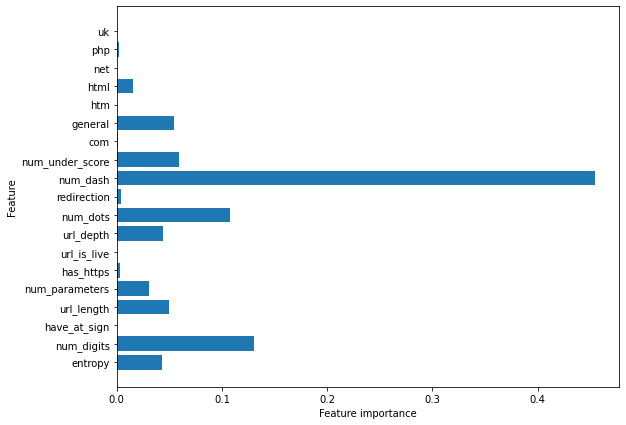

In [326]:
plot_feature_importances(X_train.shape[1], tree.feature_importances_, X_train.columns)

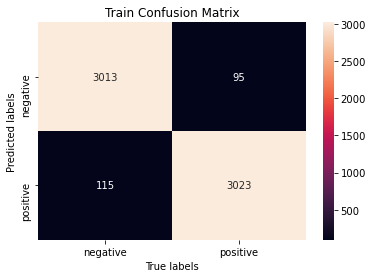

In [315]:
test_conf_matrix = confusion_matrix(y_test, y_test_tree)
plot_confusion_matrix(test_conf_matrix)

## Multilayer Perceptrons

In [327]:
# Multilayer Perceptrons model

# instantiate the model
mlp = MLPClassifier(alpha=0.001, hidden_layer_sizes=([100,100,100]))
# fit the model 
mlp.fit(X_train, y_train)

MLPClassifier(alpha=0.001, hidden_layer_sizes=[100, 100, 100])

In [328]:
#predicting the target value from the model for the samples
y_test_mlp = mlp.predict(X_test)
y_train_mlp = mlp.predict(X_train)

In [329]:
#computing the accuracy of the model performance
acc_train_mlp = accuracy_score(y_train,y_train_mlp)
acc_test_mlp = accuracy_score(y_test,y_test_mlp)
summary_table.add_row('Multilayer Perceptrons', acc_train_mlp, acc_test_mlp)
print("Multilayer Perceptrons: Accuracy on training Data: {:.3f}".format(acc_train_mlp))
print("Multilayer Perceptrons: Accuracy on test Data: {:.3f}".format(acc_test_mlp))
class_report = classification_report(y_test, y_test_mlp)
print(class_report)

Multilayer Perceptrons: Accuracy on training Data: 0.991
Multilayer Perceptrons: Accuracy on test Data: 0.980
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3108
           1       0.99      0.97      0.98      3138

    accuracy                           0.98      6246
   macro avg       0.98      0.98      0.98      6246
weighted avg       0.98      0.98      0.98      6246



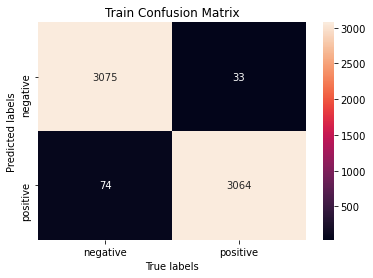

In [314]:
test_conf_matrix = confusion_matrix(y_test, y_test_mlp)
plot_confusion_matrix(test_conf_matrix)

## Random Forest

In [290]:

param_grid = {
 'max_depth': [4, 8, 16],
 'n_estimators': [1, 2, 5, 10]
}
rf = RandomForestClassifier(n_jobs=-1)
clf = GridSearchCV(estimator = rf, param_grid = param_grid, scoring = 'roc_auc')
clf.fit(X_train,y_train)


GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1),
             param_grid={'max_depth': [4, 8, 16],
                         'n_estimators': [1, 2, 5, 10]},
             scoring='roc_auc')

In [291]:
clf.best_params_

{'max_depth': 16, 'n_estimators': 10}

In [292]:
rf_clf = RandomForestClassifier(max_depth = clf.best_params_['max_depth'], 
                                n_estimators=clf.best_params_['n_estimators'])
rf_clf.fit(X_train,y_train)

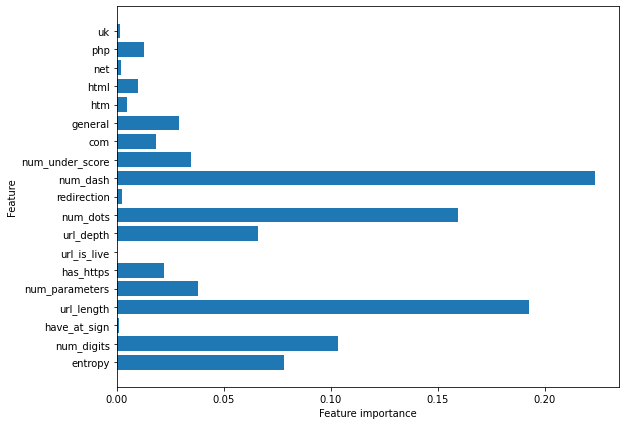

In [318]:
plot_feature_importances(X_train.shape[1], rf_clf.feature_importances_, X_train.columns)

In [321]:
# Making predictions
test_conf = rf_clf.predict(X_test)
train_conf = rf_clf.predict(X_train)
# computing the accuracy of the model performance
acc_train_rf = accuracy_score(y_train, train_conf)
acc_test_rf = accuracy_score(y_test, test_conf)
summary_table.add_row('Random Forest', acc_train_rf, acc_test_rf, clf.best_params_['max_depth'], clf.best_params_['n_estimators'])
print("Random Forest: Accuracy on training Data: {:.3f}".format(acc_train_rf))
print("Random Forest: Accuracy on test Data: {:.3f}".format(acc_test_rf))

Random Forest: Accuracy on training Data: 0.998
Random Forest: Accuracy on test Data: 0.985


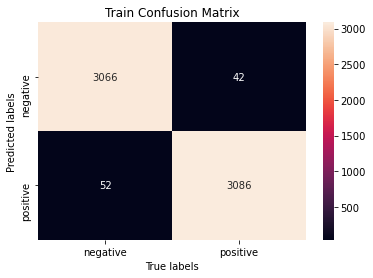

In [313]:
plot_confusion_matrix(test_conf_matrix)

# Summary

In [330]:
summary_table.show()

+------------------------+--------------------+--------------------+-----------+--------------+
|       Algorithm        |   Train Accuracy   |   Test Accuracy    | Max_depth | n_estimators |
+------------------------+--------------------+--------------------+-----------+--------------+
|     Random Forest      | 0.9980387447966699 | 0.9849503682356708 |     16    |      10      |
|     Decision Tree      | 0.9797070124879923 | 0.9674991994876722 |     10    |     None     |
| Multilayer Perceptrons | 0.9906740313800833 | 0.9795068844060199 |    None   |     None     |
+------------------------+--------------------+--------------------+-----------+--------------+
